In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from datetime import datetime, timedelta
import time
import matplotlib.pylab as plt
from datasets import Dataset,DatasetDict
from transformers import AutoModelForSequenceClassification,AutoTokenizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import stats as st
import tensorflow_hub as hub

import os

!pip install praw
import praw

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 6.9 MB/s eta 0:00:00


In [2]:
!git clone https://github.com/guptarohit/cryptoCMD.git

Cloning into 'cryptoCMD'...
remote: Enumerating objects: 525, done.
remote: Counting objects: 100% (98/98), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 525 (delta 68), reused 70 (delta 56), pack-reused 427
Receiving objects: 100% (525/525), 141.80 KiB | 7.09 MiB/s, done.
Resolving deltas: 100% (275/275), done.


In [3]:
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [4]:
reddit_read_only = praw.Reddit(client_id="bd99zeTBtdOI1Oi3J4t80Q",         # your client id
                               client_secret="HFqgHuQi-Q7uWdN8QR9l5dXdql-dlw",      # your client secret
                               user_agent="red")

In [5]:
subreddits = [
'cryptocurrency','bitcoin','cryptomoonshots' ,'ethtrader','dogecoin',
'cryptomarkets','crypto_com' ,'cryptocurrencytrading' ,'loopringorg' ,'ethereum',
'binance' ,'btc' ,'kucoin' ,'coinbase' ,'crypto_general','cardano' ,'satoshistreetbets',
'ethermining' ,'crypto_currency_news' ,'solana' ,'cryptocurrencymemes' ,'bitcoinbeginners' ,
'cryptocurrencies' ,'monero' ,'nicehash' ,'ethdev' ,'altcoin','bitcoinmining','gpumining' ,
'cryptotechnology' ,'bitcoincash' ,'tezos' ,'xrp','decentraland' ,'neo' ,'nanocurrency' ,
'ripple' ,'polkadot' ,'uniswap' ,'eos' ,'litecoin' ,'batproject' ,'bitcoinmarkets','tronix' ,
'ethfinance' ,'stellar' ,'vechain' ,'iota' ,'litecoinmarkets'
]

In [6]:
data = pd.DataFrame(columns =("title", "selftext", "score","num_comments", "date_created",
                  "created", "total_awards_received"))
for subred in subreddits :
    try:
        subreddit = reddit_read_only.subreddit(subred)
        posts = subreddit.top(time_filter="year")

        posts_dict = {"title": [], "selftext": [],
                      "id": [], "score": [],
                      "num_comments": [], "upvote_ratio": [], "date_created": [],
                      "created": [] , "total_awards_received": []
                      }

        for post in posts:

          posts_dict["title"].append(post.title)

          posts_dict["selftext"].append(post.selftext)

          posts_dict["id"].append(post.id)

          posts_dict["score"].append(post.score)

          posts_dict["num_comments"].append(post.num_comments)

          posts_dict["upvote_ratio"].append(post.upvote_ratio)

          posts_dict["date_created"].append(post.created_utc)

          posts_dict["created"].append(post.created)

          posts_dict["total_awards_received"].append(post.total_awards_received)

        # Saving the data in a pandas dataframe
        top_posts = pd.DataFrame(posts_dict)
        data = pd.concat([data, top_posts], ignore_index=True)
    
    except Exception as e:
        if "received 404 HTTP response" in str(e):
            print(f"Subreddit {subred} not found. Skipping...")
        else:
            print(f"An error occurred while processing {subred}: {str(e)}")


In [7]:
# Shuffle the rows
data = data.sample(frac=1, random_state=42)  # frac=1 means shuffle all rows, random_state for reproducibility

# Reset the index
data.reset_index(drop=True, inplace=True)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4900 entries, 0 to 4899
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  4900 non-null   object 
 1   selftext               4900 non-null   object 
 2   score                  4900 non-null   object 
 3   num_comments           4900 non-null   object 
 4   date_created           4900 non-null   float64
 5   created                4900 non-null   float64
 6   total_awards_received  4900 non-null   object 
 7   id                     4900 non-null   object 
 8   upvote_ratio           4900 non-null   float64
dtypes: float64(3), object(6)
memory usage: 344.7+ KB


There are multiple columns and not all have data on every row.  The feature I am most interested is the content of the **selftext** which makes up a little more than half of the posts at first glance.  However even looking at the first 10 rows , we can see the string [removed] is used as a stand in for null-data.  To clean up this data we will:

1. Clarify 'created' by renaming it to 'date_created' and converting timestamp to human readable date (YYYY-MM-DD)
2. Keep meta data about text that informs how much the community engaged with the post (upvote ratio, score, total awards recieved , total number of comments)
3. Remove any posts that have less than 20 characters of text in the selftext feature
4. Drop the rest of the features 


In [92]:
data['date_created'] = pd.to_datetime(data['date_created'], unit='s').dt.strftime('%Y-%m-%d')

data.drop(columns=['created'], inplace=True)

data.head(10)

,title,selftext,score,num_comments,date_created,total_awards_received,id,upvote_ratio
0,"VeChain Daily Discussion - January 31, 2023",# Welcome to the Daily VeChain Discussion!\n\n...,148,25,2023-01-31,0,10pyf6c,0.99
1,Kakele Online is an MMORPG that allows users t...,,173,18,2022-10-06,0,xx6dhh,0.97
2,TIL that Edward Snowden saved Ethereum from th...,I was reading Andreas Antonopoulos and Gavin W...,783,126,2022-12-12,0,zk5mut,0.88
3,Let's remember that TRON is decentralized,"No matter what happens to anyone, including JS...",19,3,2023-03-23,0,11z9l2e,0.96
4,Centralised exchanges are safe… until they’re not,It’s been hard to ignore the events of recent ...,36,14,2022-11-14,0,yusj7v,0.97
5,"VeChain Daily Discussion - December 05, 2022",# Welcome to the Daily VeChain Discussion!\n\n...,157,29,2022-12-05,0,zd6625,0.99
6,Nouriel Roubini says 'literally 90% of crypto ...,,96,51,2023-01-18,0,10fdxjh,0.88
7,Probably nothing.,,148,72,2023-01-06,0,1054bls,0.96
8,the Decentralized Exchange by USDC issuer Circ...,,41,2,2023-04-27,0,1313nf8,0.80
9,"RBIF, part of Robo Global Investment (RGI)",What Is Robo Inu Finance (RBIF)?\n\nRobo Inu F...,17,8,2022-12-28,0,zxdf3a,0.75


In [93]:
data = data[data ['selftext'].str.len() >= 20]
data.head(10)

,title,selftext,score,num_comments,date_created,total_awards_received,id,upvote_ratio
0,"VeChain Daily Discussion - January 31, 2023",# Welcome to the Daily VeChain Discussion!\n\n...,148,25,2023-01-31,0,10pyf6c,0.99
2,TIL that Edward Snowden saved Ethereum from th...,I was reading Andreas Antonopoulos and Gavin W...,783,126,2022-12-12,0,zk5mut,0.88
3,Let's remember that TRON is decentralized,"No matter what happens to anyone, including JS...",19,3,2023-03-23,0,11z9l2e,0.96
4,Centralised exchanges are safe… until they’re not,It’s been hard to ignore the events of recent ...,36,14,2022-11-14,0,yusj7v,0.97
5,"VeChain Daily Discussion - December 05, 2022",# Welcome to the Daily VeChain Discussion!\n\n...,157,29,2022-12-05,0,zd6625,0.99
9,"RBIF, part of Robo Global Investment (RGI)",What Is Robo Inu Finance (RBIF)?\n\nRobo Inu F...,17,8,2022-12-28,0,zxdf3a,0.75
13,Flawless ETH unstake & covert,"Seeing I rarely see any positive posts, here y...",41,15,2023-05-01,0,134sjj3,0.88
14,"Fenrir, the people",I think it's a pretty good time to tell a stor...,39,9,2022-11-14,0,yuqyoo,0.87
15,which wallet gives the best experience when in...,And what makes it special 🙂,27,34,2022-09-22,0,xkuiok,0.94
16,MINING ADDICTION - Another rig build [RTX 3070],"The addiction is real... Call me crazy, call m...",23,25,2022-10-20,0,y8tpy5,0.70


There is one more major data cleaning task for these reddit posts before moving on to bitcoin prices.  Everyday there is an automatic post for Bitcoin discussions.  None of the data collected here is the context of comments, however the metadata from this post is extremely interesting. Because the user (a bot) and the text is the  same everytime, the differences in engagement everyday *could* be generalized to the level of engagement with BTC overtime.  However, we do not want the daily posts to affect our word counts so it will be deleted.  The full context of the selftext can be seen below. 

In [94]:
sticky_message = "Please utilize this sticky thread for"

# Create a boolean mask to filter rows starting with sticky_message
mask = data['selftext'].str.startswith(sticky_message)

# Set the matching rows to None
data.loc[mask, 'selftext'] = None

# Drop rows with selftext set to None
data.dropna(subset=['selftext'], inplace=True)


In [95]:
data

,title,selftext,score,num_comments,date_created,total_awards_received,id,upvote_ratio
0,"VeChain Daily Discussion - January 31, 2023",# Welcome to the Daily VeChain Discussion!\n\n...,148,25,2023-01-31,0,10pyf6c,0.99
2,TIL that Edward Snowden saved Ethereum from th...,I was reading Andreas Antonopoulos and Gavin W...,783,126,2022-12-12,0,zk5mut,0.88
3,Let's remember that TRON is decentralized,"No matter what happens to anyone, including JS...",19,3,2023-03-23,0,11z9l2e,0.96
4,Centralised exchanges are safe… until they’re not,It’s been hard to ignore the events of recent ...,36,14,2022-11-14,0,yusj7v,0.97
5,"VeChain Daily Discussion - December 05, 2022",# Welcome to the Daily VeChain Discussion!\n\n...,157,29,2022-12-05,0,zd6625,0.99
...,...,...,...,...,...,...,...,...
4884,Buy land in district. Pros and cons?,"Hi,\nI'm very new in metaverse world.\nI'm con...",11,12,2022-10-28,0,yf7wbj,0.87
4889,Higher Inflation: How to Get Profit When Price...,* Gas prices have continued to fall and will c...,11,5,2022-09-28,0,xqey2w,0.93
4892,The Need for Privacy on the Blockchain,\n\nWhile blockchain networks are more secure...,60,37,2022-11-16,0,yx8m70,0.89
4893,Tezos ecosystem October recap! All main events...,It's time to recap all important updates of O...,67,10,2022-11-01,0,yjiqwj,0.98


In [96]:


max_num_posts = st.mode(data.date_created)[1][0]
num_days = len(data.date_created.unique())
df_dates = pd.DataFrame({'date': data.date_created.unique()})
ls_text = [" "] * num_days



ds_meta = np.zeros(shape = (num_days,max_num_posts,4))  # Array for meta data related to posts
ds_sticky = np.zeros(shape = (num_days,4))
for date, d in zip(data.date_created.unique(), np.arange(num_days)):
    temp_df = data[data.date_created == date]
    try:
        ds_sticky[d] =  sticky_df[sticky_df.date_created == date].upvote_ratio.values[0],
        sticky_df[sticky_df.date_created == date].score.values[0],
        sticky_df[sticky_df.date_created == date].total_awards_received.values[0], 
        sticky_df[sticky_df.date_created == date].num_comments.values[0]
        #print(temp_df)
    except:
        print("Day ", date, " is probably missing from stickied post")
    
    for row in range(len(temp_df.index)):#, np.arange(len(data[data.date_created == date]))):
      #  print(temp_df.iloc[row].selftext)
        ls_text[d] = ls_text[d] + " " + str(temp_df.iloc[row].selftext)
        ds_meta[d][row] = temp_df.iloc[row].upvote_ratio,temp_df.iloc[row].score, temp_df.iloc[row].total_awards_received, temp_df.iloc[row].num_comments 
        
        

Day  2023-01-31  is probably missing from stickied post
Day  2022-12-12  is probably missing from stickied post
Day  2023-03-23  is probably missing from stickied post
Day  2022-11-14  is probably missing from stickied post
Day  2022-12-05  is probably missing from stickied post
Day  2022-12-28  is probably missing from stickied post
Day  2023-05-01  is probably missing from stickied post
Day  2022-09-22  is probably missing from stickied post
Day  2022-10-20  is probably missing from stickied post
Day  2023-05-02  is probably missing from stickied post
Day  2022-12-27  is probably missing from stickied post
Day  2022-11-10  is probably missing from stickied post
Day  2023-02-18  is probably missing from stickied post
Day  2022-12-25  is probably missing from stickied post
Day  2023-01-09  is probably missing from stickied post
Day  2023-02-17  is probably missing from stickied post
Day  2023-08-15  is probably missing from stickied post
Day  2023-01-08  is probably missing from sticki

In [97]:
data.to_pickle("/kaggle/working/data.pkl")  
data = pd.read_pickle("/kaggle/working/data.pkl")

In [1]:
!pip install cryptocmd

In [98]:
# Scrape bitcoin news data
def scrape_bitcoin_price(start_date,end_date):
    from datetime import datetime

    # Convert start_date and end_date to datetime objects
    start_date_datetime = datetime.strptime(start_date, "%Y%m%d")
    end_date_datetime = datetime.strptime(end_date, "%Y%m%d")

    # Format the datetime objects as "DD-MM-YYYY" strings
    start_date_formatted = start_date_datetime.strftime("%d-%m-%Y")
    end_date_formatted = end_date_datetime.strftime("%d-%m-%Y")

    from cryptocmd import CmcScraper

    # initialise scraper with time interval
    scraper = CmcScraper("BTC", start_date_formatted,end_date_formatted)

    # get raw data as list of list
    headers, data = scraper.get_data()

    # get data in a json format
    json_data = scraper.get_data("json")

    # export the data to csv
    scraper.export("csv")

    # get dataframe for the data
    df = scraper.get_dataframe()


    # Create dataframe and convert columns to right data types
    df_price = pd.DataFrame(columns=['date','open','high','low','price','total_volume','market_cap'])
    df_price['date'] = df['Date'].astype('datetime64[ns]')
    df_price['open'] = df['Open'].astype(float)
    df_price['high'] = df['High'].astype(float)
    df_price['low'] = df['Low'].astype(float)
    df_price['price'] = df['Close'].astype(float)
    #df_price['close'] = df['Close'].astype(float)
    df_price['total_volume'] = df['Volume'].astype(str).str.replace(',', '').astype(float)
    df_price['market_cap'] = df['Market Cap'].astype(str).str.replace(',', '').astype(float)
    df_price.sort_values(by=['date'],inplace=True)
    df_price.reset_index(drop=True,inplace=True)

    print(df.head())
    print(df_price .head())
    
    return df_price

In [99]:
data['date_created'] = pd.to_datetime(data['date_created'])

start_date = min(data['date_created']).strftime("%Y%m%d")
end_date = max(data['date_created']).strftime("%Y%m%d")
prices = scrape_bitcoin_price(start_date,end_date)

        Date          Open          High           Low         Close  \
0 2023-09-21  27129.840021  27152.938580  26389.300286  26567.632904   
1 2023-09-20  27210.228492  27379.506074  26864.082320  27132.007340   
2 2023-09-19  26760.851006  27488.763802  26681.605775  27211.117820   
3 2023-09-18  26532.994794  27414.734259  26415.515846  26754.281038   
4 2023-09-17  26567.927583  26617.997628  26445.075125  26534.187517   

         Volume    Market Cap  
0  1.337144e+10  5.178643e+11  
1  1.328112e+10  5.288420e+11  
2  1.380769e+10  5.303585e+11  
3  1.561534e+10  5.214319e+11  
4  6.774211e+09  5.171168e+11  
        date          open          high           low         price  \
0 2022-09-21  18891.282890  19674.630331  18290.315188  18547.399760   
1 2022-09-22  18534.649595  19456.910901  18415.591497  19413.551621   
2 2022-09-23  19412.399925  19464.672348  18617.553010  19297.637840   
3 2022-09-24  19296.990704  19310.197608  18861.973999  18937.011176   
4 2022-09-25  1

In [100]:
prices.head(10)

,date,open,high,low,price,total_volume,market_cap
0,2022-09-21,18891.282890,19674.630331,18290.315188,18547.399760,4.636379e+10,3.553149e+11
1,2022-09-22,18534.649595,19456.910901,18415.591497,19413.551621,4.113577e+10,3.719240e+11
2,2022-09-23,19412.399925,19464.672348,18617.553010,19297.637840,3.889608e+10,3.697190e+11
3,2022-09-24,19296.990704,19310.197608,18861.973999,18937.011176,2.614964e+10,3.628265e+11
4,2022-09-25,18936.311515,19134.733194,18696.468304,18802.097976,2.335997e+10,3.602593e+11
5,2022-09-26,18803.900633,19274.873498,18721.285851,19222.672184,4.414880e+10,3.683359e+11
6,2022-09-27,19221.840713,20338.455461,18915.668722,19110.546551,5.857144e+10,3.662027e+11
7,2022-09-28,19104.620790,19688.344373,18553.297358,19426.721332,5.307130e+10,3.722796e+11
8,2022-09-29,19427.780191,19589.266211,18924.353453,19573.050314,4.103784e+10,3.751009e+11
9,2022-09-30,19573.431421,20109.850301,19265.662400,19431.789447,4.397525e+10,3.724147e+11


In [101]:
prices = prices.sort_values(by="date")
data = data.sort_values(by="date_created")

In [102]:
prices.head()

,date,open,high,low,price,total_volume,market_cap
0,2022-09-21,18891.282890,19674.630331,18290.315188,18547.399760,4.636379e+10,3.553149e+11
1,2022-09-22,18534.649595,19456.910901,18415.591497,19413.551621,4.113577e+10,3.719240e+11
2,2022-09-23,19412.399925,19464.672348,18617.553010,19297.637840,3.889608e+10,3.697190e+11
3,2022-09-24,19296.990704,19310.197608,18861.973999,18937.011176,2.614964e+10,3.628265e+11
4,2022-09-25,18936.311515,19134.733194,18696.468304,18802.097976,2.335997e+10,3.602593e+11


In [103]:

def add_price_forecast(prices, forecast_days):
    col_names = prices.columns
    # First Start fresh by deleting any previous forecast data"
    end_date = max(prices['date'])
    print(col_names)
    for col in col_names:
        if col.startswith("forecast"):
            prices.drop(col, axis = 1, inplace = True)
    
    for day in forecast_days:
        prices["forecast_" + str(day)] = 0
        prices["forecast_" + str(day) +"b"] = 0  #b for binary
    
   
    for i in prices.index:
        for days in forecast_days:
            stop_date = i +  days
            
            
            if stop_date < len(prices):
                try:
                    prices.loc[i, "forecast_" + str(days)] = (prices.loc[stop_date,'price'] - prices.loc[i,'price']) / prices.loc[i,'price']
                    if prices.loc[i, "forecast_" + str(days)] > 0:
                        prices.loc[i,"forecast_" + str(days) +"b"] = 1
                except Exception as e:
                    None
                    print(e)
                
        
    
    return prices






try:
    prices['date'] = (prices['date']).apply(lambda x: datetime.fromisoformat(x).date())
except Exception as e:
    print(e)
try:
    prices.drop(['total_volume', 'market_cap', 'coin_name'] ,axis = 1, inplace = True)
    
except:
    None
prices.head(10)
forecast_days = [1,3,5,7,10]



fromisoformat: argument must be str


In [104]:
prices = add_price_forecast(prices, forecast_days)
print("Price Data ranges from " , min(prices['date']), " to " , (max(prices['date'])))
print("Reddit Data ranges from " , min(data['date_created']), " to " , (max(data['date_created'])))
prices = prices[prices['date'] >= min(data['date_created'])]
print("New Price Data ranges from " , min(prices['date']), " to " , (max(prices['date'])))

prices.head(10)


Index(['date', 'open', 'high', 'low', 'price', 'total_volume', 'market_cap'], dtype='object')
Price Data ranges from  2022-09-21 00:00:00  to  2023-09-21 00:00:00
Reddit Data ranges from  2022-09-21 00:00:00  to  2023-09-21 00:00:00
New Price Data ranges from  2022-09-21 00:00:00  to  2023-09-21 00:00:00


,date,open,high,low,price,total_volume,market_cap,forecast_1,forecast_1b,forecast_3,forecast_3b,forecast_5,forecast_5b,forecast_7,forecast_7b,forecast_10,forecast_10b
0,2022-09-21,18891.282890,19674.630331,18290.315188,18547.399760,4.636379e+10,3.553149e+11,0.046699,1,0.021006,1,0.036408,1,0.047409,1,0.041229,1
1,2022-09-22,18534.649595,19456.910901,18415.591497,19413.551621,4.113577e+10,3.719240e+11,-0.005971,0,-0.031496,0,-0.015608,0,0.008216,1,-0.019030,0
2,2022-09-23,19412.399925,19464.672348,18617.553010,19297.637840,3.889608e+10,3.697190e+11,-0.018688,0,-0.003885,0,0.006689,1,0.006952,1,0.016890,1
3,2022-09-24,19296.990704,19310.197608,18861.973999,18937.011176,2.614964e+10,3.628265e+11,-0.007124,0,0.009164,1,0.033587,1,0.019807,1,0.073920,1
4,2022-09-25,18936.311515,19134.733194,18696.468304,18802.097976,2.335997e+10,3.602593e+11,0.022368,1,0.033221,1,0.033490,1,0.012871,1,0.072259,1
5,2022-09-26,18803.900633,19274.873498,18721.285851,19222.672184,4.414880e+10,3.683359e+11,-0.005833,0,0.018227,1,0.004652,1,0.020856,1,0.038120,1
6,2022-09-27,19221.840713,20338.455461,18915.668722,19110.546551,5.857144e+10,3.662027e+11,0.016545,1,0.016810,1,-0.003477,0,0.064169,1,0.022830,1
7,2022-09-28,19104.620790,19688.344373,18553.297358,19426.721332,5.307130e+10,3.722796e+11,0.007532,1,-0.005900,0,0.010133,1,0.037783,1,-0.000523,0
8,2022-09-29,19427.780191,19589.266211,18924.353453,19573.050314,4.103784e+10,3.751009e+11,-0.007217,0,-0.027024,0,0.039023,1,0.019537,1,-0.006469,0
9,2022-09-30,19573.431421,20109.850301,19265.662400,19431.789447,4.397525e+10,3.724147e+11,-0.006160,0,0.009870,1,0.037512,1,0.005921,1,-0.014940,0


In [105]:
prices.to_pickle("/kaggle/working/prices.pkl")  
prices = pd.read_pickle("/kaggle/working/prices.pkl")

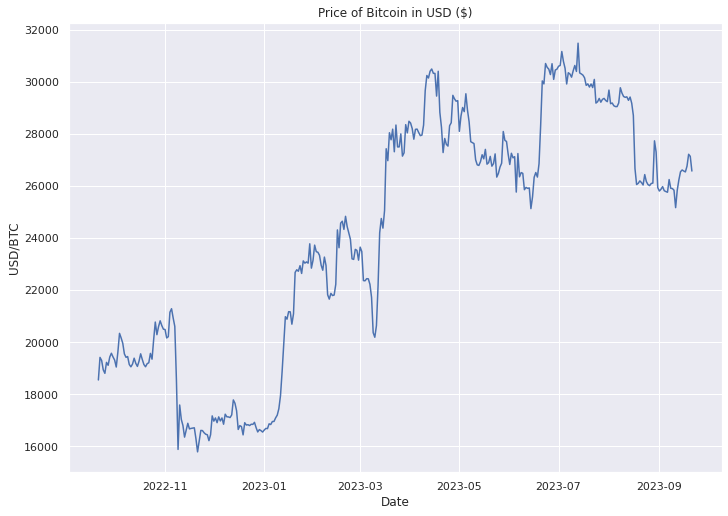

In [106]:
ax = sns.lineplot(x = prices['date'], y = prices['price'])
ax.set(title = "Price of Bitcoin in USD ($)", ylabel = 'USD/BTC', xlabel = "Date")
plt.show()

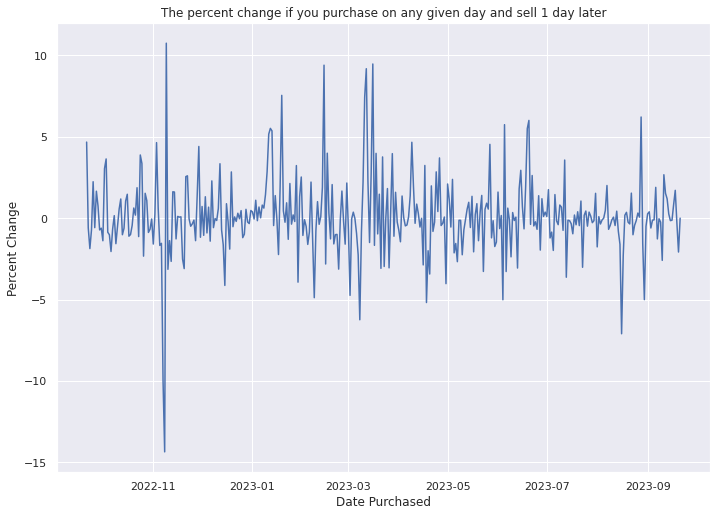

In [107]:
ax = sns.lineplot(x = prices['date'], y = prices['forecast_1']*100)
ax.set(title = "The percent change if you purchase on any given day and sell 1 day later", ylabel = 'Percent Change', xlabel = "Date Purchased")
plt.show()

Even though BTC has had a rough year, there are just slightly more days where the price of bitcoin goes down (0) than when it goes up (1).  That means that there is still money to be made if we can properly time these fluctuations

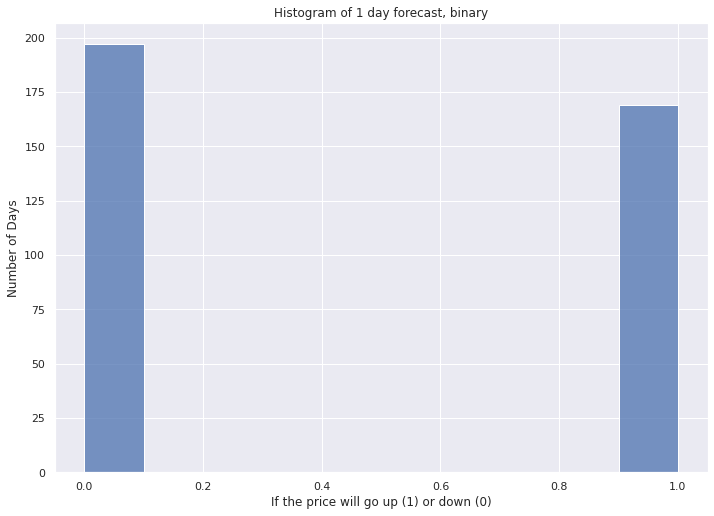

In [108]:
ax = sns.histplot(prices['forecast_1b'])
ax.set(xlabel = "If the price will go up (1) or down (0)", ylabel = 'Number of Days', title = "Histogram of 1 day forecast, binary")
plt.show()

In [109]:

td = int(.1 * len(df_dates))
rand_ind = df_dates.sample(frac = 1).index
print(rand_ind)
test_dates =  [val for (_, val) in sorted(zip(rand_ind, df_dates.date), key=lambda x: x[0])][:td]
train_dates = [val for (_, val) in sorted(zip(rand_ind, df_dates.date), key=lambda x: x[0])][td:]

test_text = np.array([val for (_, val) in sorted(zip(rand_ind, ls_text), key=lambda x: x[0])][:td])
train_text = np.array([val for (_, val) in sorted(zip(rand_ind, ls_text), key=lambda x: x[0])][td:])

test_meta = np.array([val for (_, val) in sorted(zip(rand_ind, ds_meta), key=lambda x: x[0])][:td])
train_meta = np.array([val for (_, val) in sorted(zip(rand_ind, ds_meta), key=lambda x: x[0])][td:])

test_sticky =  np.array([val for (_, val) in sorted(zip(rand_ind, ds_sticky), key=lambda x: x[0])][:td])
train_sticky = np.array([val for (_, val) in sorted(zip(rand_ind, ds_sticky), key=lambda x: x[0])][td:])

test_y =  np.array([val for (_, val) in sorted(zip(rand_ind, prices.forecast_1), key=lambda x: x[0])][:td])
train_y = np.array([val for (_, val) in sorted(zip(rand_ind, prices.forecast_1), key=lambda x: x[0])][td:] )




Int64Index([321, 277, 157, 165,  13, 170, 218,   5, 122,  27,
            ...
             80, 335,  65, 120, 281, 320, 268, 290, 273,  53],
           dtype='int64', length=346)


In [110]:
print(ds_sticky)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


# Building Models

Below are the archetictures for simple multi-input regression models for predicting price

In [111]:



text_input = keras.Input( shape = (),  dtype= tf.string, name = "Self Text " )

sticky_input = keras.Input(shape = (4,), dtype = tf.float64, name =  "Daily Stickied Post Metadata")

meta_input = keras.Input(shape = (max_num_posts, 4,), dtype = tf.float64, name =  "Post Metadata")

fl_input = layers.Flatten()(sticky_input)

f2_input = layers.Flatten()(meta_input)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)(text_input)


dense_layer1 = tf.keras.layers.Dense(16, activation='linear')(hub_layer)
text_guess = layers.Dense(1, name="textguess")(dense_layer1)



dense_layer2 = tf.keras.layers.Dense(32, activation='linear')(fl_input)
dense_layer3 = tf.keras.layers.Dense(8, activation='linear')(dense_layer2)
dense_layer4 = tf.keras.layers.Dense(4, activation='linear')(dense_layer3)
sticky_guess = layers.Dense(1, name="stickiedguess")(dense_layer4)


dense_layer5 = tf.keras.layers.Dense(64, activation='linear')(f2_input)
dense_layer6 = tf.keras.layers.Dense(32, activation='linear')(dense_layer5)
dense_layer7 = tf.keras.layers.Dense(16, activation='linear')(dense_layer6)
dense_layer8 = tf.keras.layers.Dense(8, activation='linear')(dense_layer7)
dense_layer9 = tf.keras.layers.Dense(4, activation='linear')(dense_layer8)
meta_guess = layers.Dense(1, name="metaguess")(dense_layer9)

# Stick a logistic regression for priority prediction on top of the features


y_hat = layers.Average()( [sticky_guess, meta_guess, text_guess])


model = keras.Model(
    inputs= [text_input, meta_input, sticky_input], 
    outputs=y_hat
)

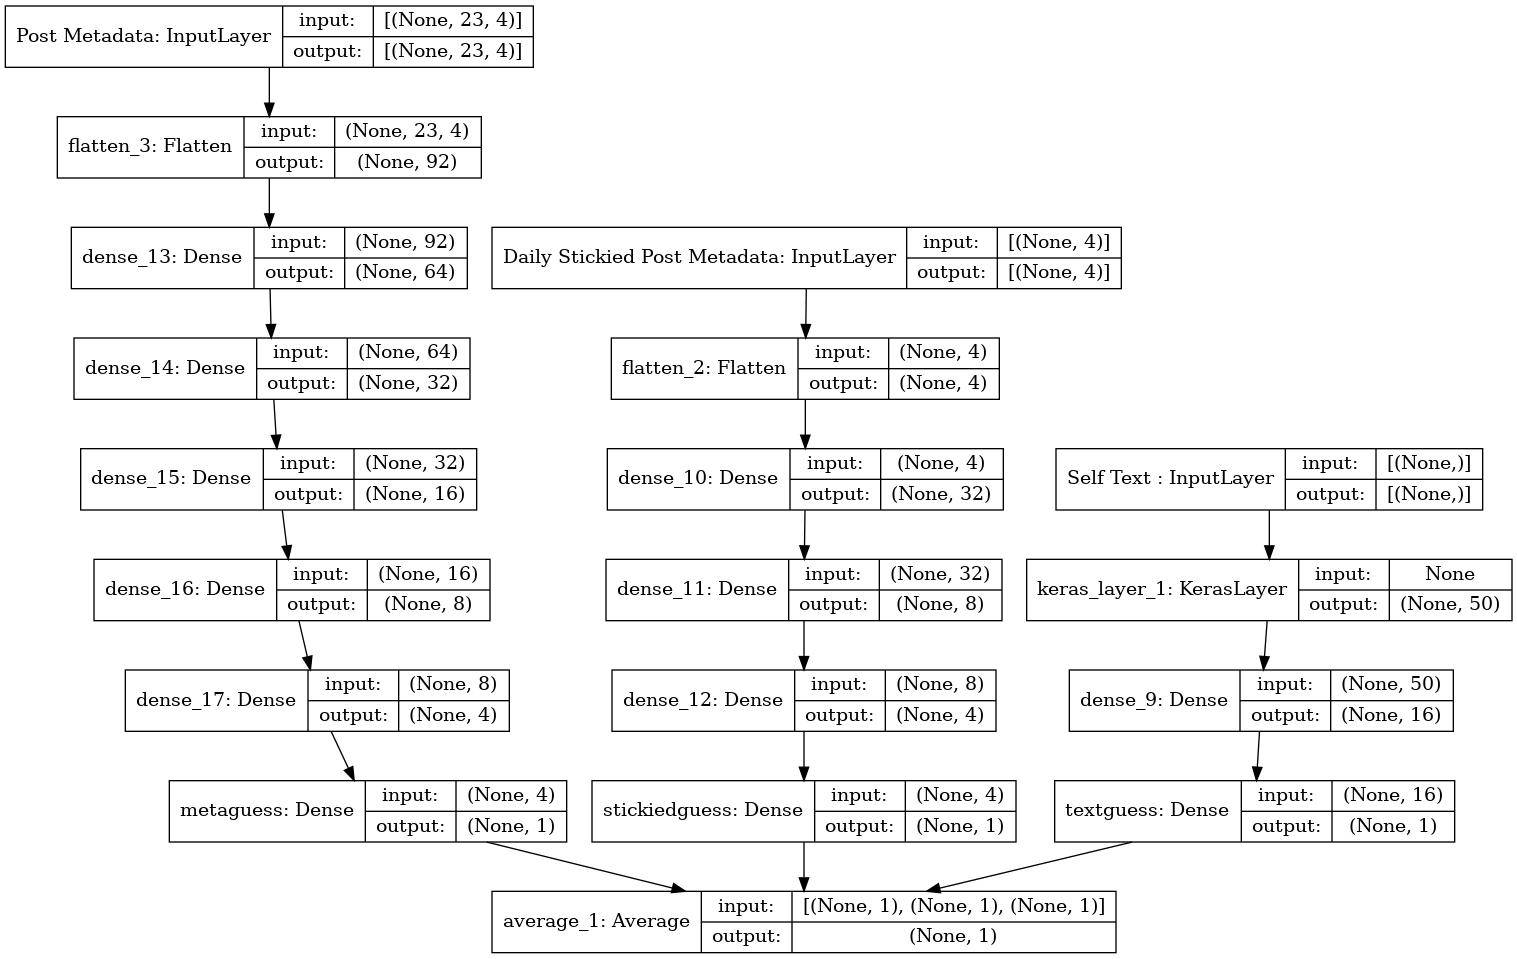

In [112]:
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

In [113]:
model.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])


In [114]:
# Assuming train_text, train_meta, train_sticky, and train_y are your data arrays
# Make sure they have the same number of samples

# Check the shapes
print(train_text.shape)
print(train_meta.shape)
print(train_sticky.shape)
print(train_y.shape)

# If they have different shapes, you may need to preprocess or align the data
# For example, you can slice or reshape the arrays as needed
# Ensure they have the same number of samples

# Example:
# train_text, train_meta, and train_sticky have different shapes
# Reshape or preprocess them as needed
# For instance, if train_text is a 2D array and you want to match the number of samples in train_y:
# train_text = train_text[:len(train_y)]

# Now, verify that all arrays have the same number of samples
print(train_text.shape)
print(train_meta.shape)
print(train_sticky.shape)
print(train_y.shape)

# Then, you can proceed with model training

(312,)
(312, 23, 4)
(312, 4)
(312,)
(312,)
(312, 23, 4)
(312, 4)
(312,)


In [115]:


history  = model.fit( x = [train_text,train_meta, train_sticky], y = train_y, batch_size = 10,  epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 3s 97ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 2/20
25/25 [==============================] - 2s 76ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 3/20
25/25 [==============================] - 2s 66ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 4/20
25/25 [==============================] - 2s 63ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 5/20
25/25 [==============================] - 2s 70ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 6/20
25/25 [==============================] - 2s 71ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 7/20
25/25 [==============================] - 2s 75ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 8/20
25/25 [==============================] - 2s 71ms/step - loss: nan - mse: nan - val_loss: nan - val_mse: nan
Epoch 9/20
25/25 [==============================

In [116]:



text_input = keras.Input( shape = (),  dtype= tf.string, name = "Self Text " )

sticky_input = keras.Input(shape = (4,), dtype = tf.float64, name =  "Daily Stickied Post Metadata")

meta_input = keras.Input(shape = (max_num_posts, 4,), dtype = tf.float64, name =  "Post Metadata")

fl_input = layers.Flatten()(sticky_input)

f2_input = layers.Flatten()(meta_input)

embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], dtype=tf.string, trainable=True)(text_input)


dense_layer1 = tf.keras.layers.Dense(16, activation='linear')(hub_layer)
text_guess = layers.Dense(1, name="textguess")(dense_layer1)



dense_layer2 = tf.keras.layers.Dense(32, activation='linear')(fl_input)
dense_layer3 = tf.keras.layers.Dense(8, activation='linear')(dense_layer2)
dense_layer4 = tf.keras.layers.Dense(4, activation='linear')(dense_layer3)
sticky_guess = layers.Dense(1, name="stickiedguess")(dense_layer4)


dense_layer5 = tf.keras.layers.Dense(64, activation='linear')(f2_input)
dense_layer6 = tf.keras.layers.Dense(32, activation='linear')(dense_layer5)
dense_layer7 = tf.keras.layers.Dense(16, activation='linear')(dense_layer6)
dense_layer8 = tf.keras.layers.Dense(8, activation='linear')(dense_layer7)
dense_layer9 = tf.keras.layers.Dense(4, activation='linear')(dense_layer8)
meta_guess = layers.Dense(1, name="metaguess")(dense_layer9)

# Stick a logistic regression for priority prediction on top of the features


y_hat = layers.Average()( [sticky_guess,  text_guess])


model1 = keras.Model(
    inputs= [text_input, meta_input, sticky_input], 
    outputs=y_hat
)

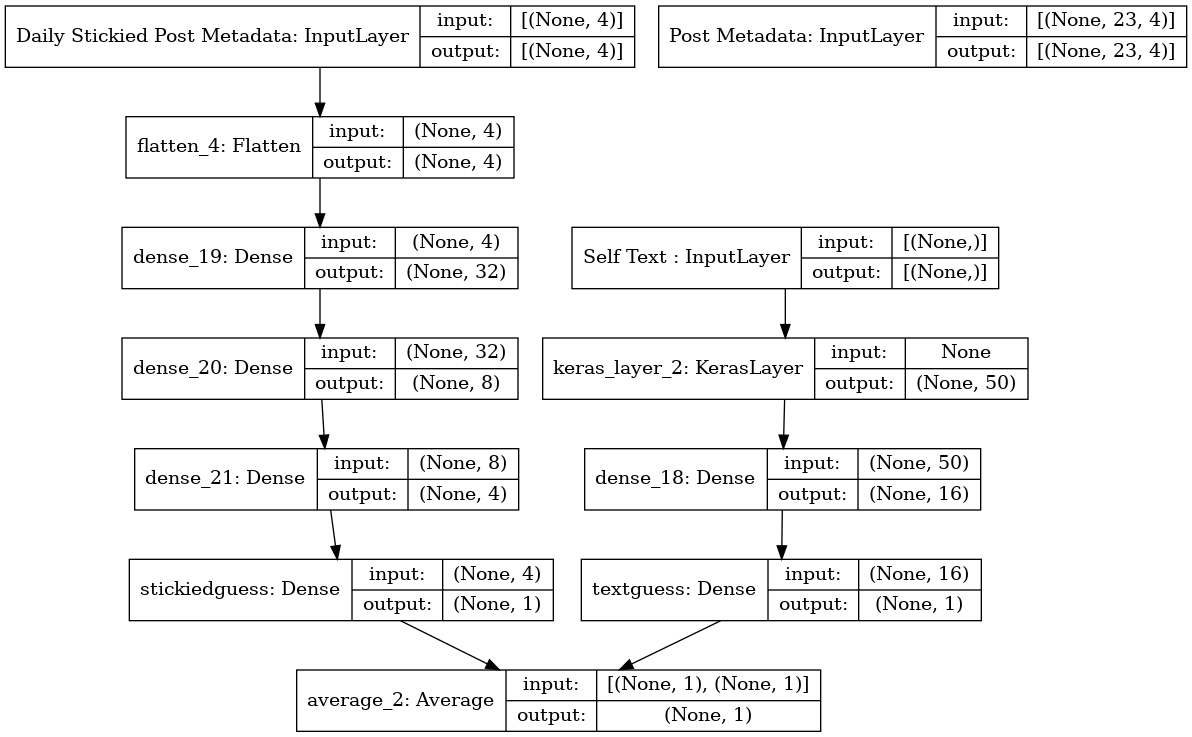

In [117]:
keras.utils.plot_model(model1, "multi_input_and_output_model.png", show_shapes=True)

In [118]:
model1.compile(optimizer='sgd',
              loss=tf.keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
              metrics=['mse'])
history1  = model1.fit( x = [train_text,train_meta, train_sticky], y = train_y, batch_size = 10,  epochs=20, validation_split=0.2)

Epoch 1/20
25/25 [==============================] - 3s 81ms/step - loss: 0.0668 - mse: 0.0668 - val_loss: 0.0330 - val_mse: 0.0330
Epoch 2/20
25/25 [==============================] - 2s 65ms/step - loss: 0.0293 - mse: 0.0293 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 3/20
25/25 [==============================] - 2s 72ms/step - loss: 0.0231 - mse: 0.0231 - val_loss: 0.0182 - val_mse: 0.0182
Epoch 4/20
25/25 [==============================] - 2s 68ms/step - loss: 0.0197 - mse: 0.0197 - val_loss: 0.0139 - val_mse: 0.0139
Epoch 5/20
25/25 [==============================] - 2s 74ms/step - loss: 0.0176 - mse: 0.0176 - val_loss: 0.0118 - val_mse: 0.0118
Epoch 6/20
25/25 [==============================] - 2s 63ms/step - loss: 0.0159 - mse: 0.0159 - val_loss: 0.0104 - val_mse: 0.0104
Epoch 7/20
25/25 [==============================] - 2s 66ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0109 - val_mse: 0.0109
Epoch 8/20
25/25 [==============================] - 2s 70ms/step - loss: 0.0137 - m

In [119]:
history_dict = history1.history
history_dict.keys()

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])

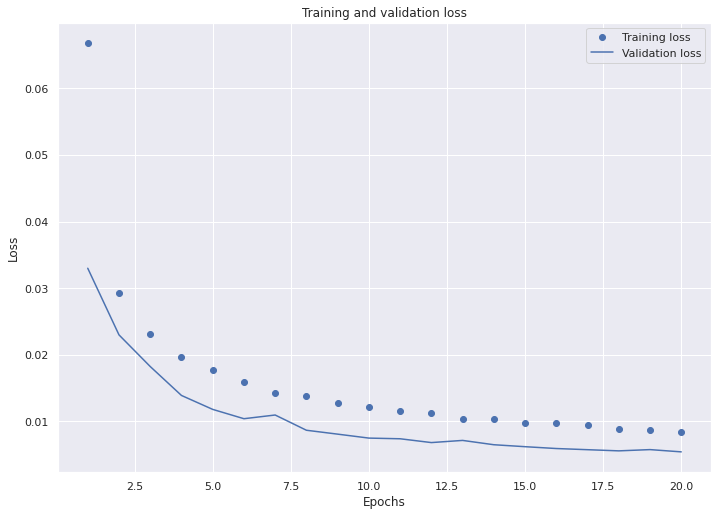

In [120]:
mse = history_dict['mse']
val_mse = history_dict['val_mse']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(mse) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

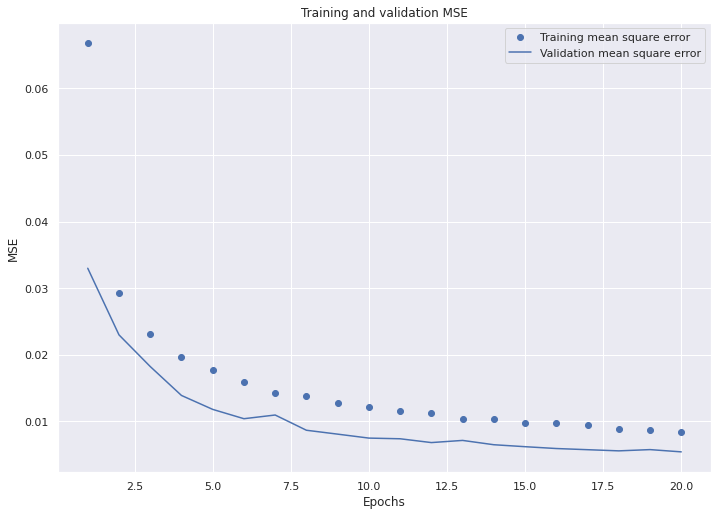

In [121]:
plt.plot(epochs, mse, 'bo', label='Training mean square error')
plt.plot(epochs, val_mse, 'b', label='Validation mean square error')
plt.title('Training and validation MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend(loc='upper right')

plt.show()

In [122]:
answer = model1.predict(x=[test_text,test_meta, test_sticky])

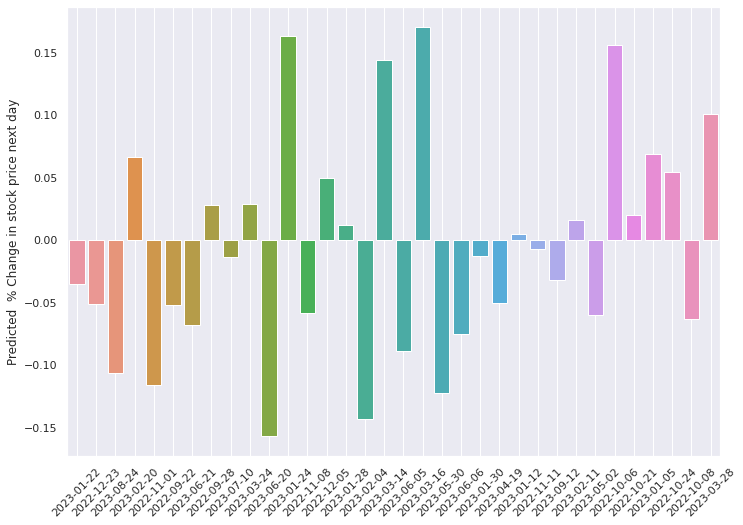

In [123]:
sns.barplot(x = test_dates, y = answer[:,0]) 
plt.xticks(rotation=45)
plt.ylabel("Predicted  % Change in stock price next day")
plt.grid()

None

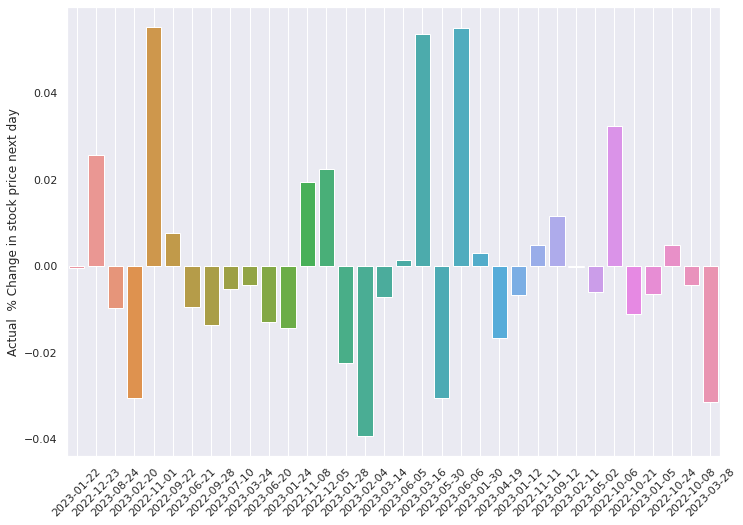

In [124]:
sns.barplot(x = test_dates, y = test_y) 
plt.ylabel("Actual  % Change in stock price next day")
plt.xticks(rotation=45)
plt.grid()
None

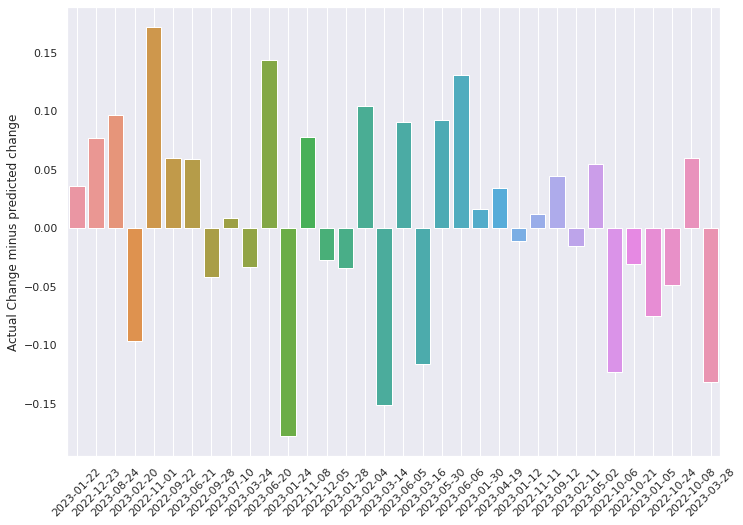

In [125]:
delta = test_y - answer[:,0]
sns.barplot(x = test_dates, y = delta )
plt.xticks(rotation=45)
plt.ylabel("Actual Change minus predicted change")
plt.grid()
None